## The Problem: compute average sales price per sqft for recently sold houses in Berkeley

#### Note to self

Spent 90 minutes installing geopandas, pandana, and osmnx.  The way I finally got it to work was using pip and installing dependencies using brew.  Avoid conda-forge.

In [20]:
import pandas as pd
import geopandas as gpd
import pandana as pdna
import osmnx as ox
%matplotlib inline

### Read in the data we want to aggregate - a file of recent sales on Redfin in Berkeley which was downloaded from redfin.com

In [175]:
df = pd.read_csv("redfin_2017-09-20-14-39-25.csv")
df = df.dropna(subset=['$/SQUARE FEET'])
df = df[df['$/SQUARE FEET'] < 1500]
df = df[df['$/SQUARE FEET'] > 380]
df = df[df['PROPERTY TYPE'] == 'Single Family Residential']
df = df.set_index("ADDRESS")
print len(df)
df.head()

230


,SALE TYPE,SOLD DATE,PROPERTY TYPE,CITY,STATE,ZIP,PRICE,BEDS,BATHS,LOCATION,...,STATUS,NEXT OPEN HOUSE START TIME,NEXT OPEN HOUSE END TIME,URL,SOURCE,MLS#,FAVORITE,INTERESTED,LATITUDE,LONGITUDE
ADDRESS,,,,,,,,,,,,,,,,,,,,,
1834 63Rd St,PAST SALE,April-18-2017,Single Family Residential,Berkeley,CA,94703,940000,2.0,1.5,Le Conte,...,Sold,NaN,NaN,http://www.redfin.com/CA/Berkeley/1834-63rd-St-94703/home/651697,EBRD/CCAR/Bay East,40771117,N,N,37.847825,-122.269773
1839 63Rd St,PAST SALE,July-28-2017,Single Family Residential,Berkeley,CA,94703,860000,2.0,1.0,Santa Fe,...,Sold,NaN,NaN,http://www.redfin.com/CA/Berkeley/1839-63rd-St-94703/home/1309093,EBRD/CCAR/Bay East,40787457,N,Y,37.848338,-122.269522
1613 5th St,PAST SALE,August-18-2017,Single Family Residential,Berkeley,CA,94710-1714,900000,2.0,1.0,West Berkeley,...,Sold,NaN,NaN,http://www.redfin.com/CA/Berkeley/1613-5th-St-94710/home/674837,EBRD/CCAR/Bay East,40790651,N,Y,37.873378,-122.300281
1946 Yosemite Rd,PAST SALE,April-26-2017,Single Family Residential,Berkeley,CA,94707,1525000,3.0,2.5,Thousand Oaks,...,Sold,NaN,NaN,http://www.redfin.com/CA/Berkeley/1946-Yosemite-Rd-94707/home/1964415,EBRD/CCAR/Bay East,40775608,N,Y,37.896316,-122.276743
2504 Grant St,PAST SALE,May-23-2017,Single Family Residential,Berkeley,CA,94703,843000,3.0,3.0,Central Berkeley,...,Sold,NaN,NaN,http://www.redfin.com/CA/Berkeley/2504-Grant-St-94703/home/1291559,EBRD/CCAR/Bay East,40779589,N,Y,37.862795,-122.274578


In [177]:
pd.set_option('display.max_colwidth', 100)
df.sort_values('$/SQUARE FEET', ascending=False).head().URL

ADDRESS
1157 Virginia St           http://www.redfin.com/CA/Berkeley/1157-Virginia-St-94702/home/1883152
1253 Hearst Ave             http://www.redfin.com/CA/Berkeley/1253-Hearst-Ave-94702/home/1460574
1326 Cornell Ave           http://www.redfin.com/CA/Berkeley/1326-Cornell-Ave-94702/home/1459089
992 SANTA BARBARA Rd    http://www.redfin.com/CA/Berkeley/992-Santa-Barbara-Rd-94707/home/705927
2932 Pine Ave                  http://www.redfin.com/CA/Berkeley/2932-Pine-Ave-94705/home/655148
Name: URL, dtype: object

In [178]:
df.sort_values('$/SQUARE FEET').head().URL

ADDRESS
6301 Herzog St                                          http://www.redfin.com/CA/Oakland/6301-Herzog-St-94608/home/531569
2800 Martin Luther King Jr Way    http://www.redfin.com/CA/Berkeley/2800-Martin-Luther-King-Junior-Way-94703/home/2000727
635 Santa Barbara Rd                             http://www.redfin.com/CA/Berkeley/635-Santa-Barbara-Rd-94707/home/700747
3046 Stanton St                                      http://www.redfin.com/CA/Berkeley/3046-Stanton-St-94702/home/1776868
6452 Regent St                                         http://www.redfin.com/CA/Oakland/6452-Regent-St-94618/home/1546253
Name: URL, dtype: object

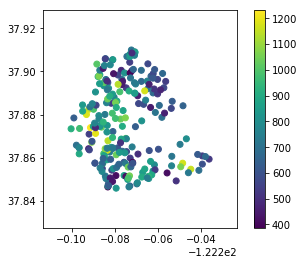

In [179]:
from shapely.geometry import Point
gdf = gpd.GeoDataFrame(df, geometry=[Point(row.LONGITUDE, row.LATITUDE) for _, row in df.iterrows()])
gdf.plot(column='$/SQUARE FEET', legend=True)

### Our first average - just use Pandas to do a group by ZIP and quantile

We could join this to shapes and make a map, but I'm too lazy to go get zip code shapes.  But this also makes the point that the street network is now a global scalable spatial geography which didn't exist a few years ago.

In [180]:
df.groupby('ZIP')['$/SQUARE FEET'].median().sort_values(ascending=False).head(10)

ZIP
94702-2149    1056.0
94703-2120    1041.0
94710-1714     918.0
94609          889.0
94706          847.5
94703          808.5
94702          780.5
94703-1707     766.0
94707          750.5
94705          747.5
Name: $/SQUARE FEET, dtype: float64

This is the traditional GIS way of doing things, but has severe boundary problems, and in cases like this, where there are only 350 sold houses, we probably need overlapping buffers to "smooth things out" rather than mutually exclusive shapes like zip codes.

*This is the purpose of pandana, to do parameterized aggregations along the street network.*

### Let's get the street network for Berkeley using osmnx

In [138]:
G = ox.graph_from_place('Berkeley, California, USA')

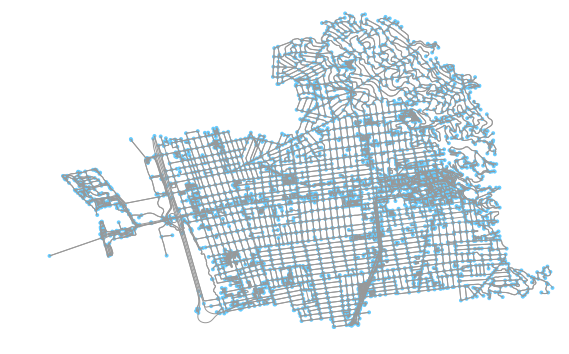

(<matplotlib.figure.Figure at 0x128d36710>,
 <matplotlib.axes._subplots.AxesSubplot at 0x126110e10>)

In [139]:
ox.plot_graph(G)

### We want it as a geodataframe

In [181]:
nodes, edges = osmnx.save_load.graph_to_gdfs(G)
# since we're in lat/lng, we need the full precision (something in osmnx lowers the precision?)
nodes["x"] = [p.x for p in nodes.geometry.values]
nodes["y"] = [p.y for p in nodes.geometry.values]
nodes.head()

,highway,osmid,ref,x,y,geometry
34351114,NaN,34351114,NaN,-122.246530,37.866153,POINT (-122.2465302 37.8661529)
34485314,NaN,34485314,NaN,-122.247001,37.866140,POINT (-122.2470015 37.8661398)
35719055,NaN,35719055,NaN,-122.244383,37.859827,POINT (-122.2443826 37.8598274)
35719092,NaN,35719092,NaN,-122.247074,37.867541,POINT (-122.2470736 37.8675411)
35719098,NaN,35719098,NaN,-122.248403,37.866058,POINT (-122.2484031 37.8660581)


In [182]:
edges.head()

,access,area,bridge,geometry,highway,key,lanes,length,maxspeed,name,oneway,osmid,ref,service,tunnel,u,v,width
0,NaN,NaN,NaN,"LINESTRING (-122.2726539 37.8884334, -122.2725838 37.8884624, -122.2725262 37.8884722, -122.2725...",tertiary,0,3,24.927042,25 mph,Hopkins Street,False,234074080,NaN,NaN,NaN,348192780,239669505,NaN
1,NaN,NaN,NaN,"LINESTRING (-122.2726539 37.8884334, -122.2726977 37.8883963, -122.2727302 37.8883495, -122.2731...",tertiary,0,3,91.657912,25 mph,Hopkins Street,False,"[234074080, 234074081]",NaN,NaN,NaN,348192780,53019172,NaN
2,NaN,NaN,NaN,"LINESTRING (-122.2726539 37.8884334, -122.272767 37.8885487, -122.2726036 37.8888229)",footway,0,NaN,49.907068,NaN,NaN,False,185454959,NaN,NaN,NaN,348192780,1960546513,NaN
3,NaN,NaN,NaN,"LINESTRING (-122.3111831 37.8651709, -122.3111414 37.8651442, -122.3110547 37.8651277, -122.3107...",residential,0,NaN,41.880507,NaN,Marina Boulevard,True,22372575,NaN,NaN,NaN,53116941,240448833,NaN
4,NaN,NaN,NaN,"LINESTRING (-122.3111831 37.8651709, -122.3111724 37.8652928, -122.3112926 37.8655503)",residential,0,NaN,44.101629,NaN,Marina Boulevard,True,22372574,NaN,NaN,NaN,53116941,240448850,NaN


### osmnx has pandana connectivity out of the box (though I think by accident)

In [183]:
net = pdna.Network(nodes.x, nodes.y, edges.u, edges.v, edges[["length"]])
net.precompute(4000)

### assign each sold house to it's nearest street intersection

In [184]:
df["node_ids"] = net.get_node_ids(df.LONGITUDE, df.LATITUDE)
df.node_ids.head()

ADDRESS
1834 63Rd St          56063268
1839 63Rd St          53122202
1613 5th St         1979167530
1946 Yosemite Rd      53082795
2504 Grant St         53020966
Name: node_ids, dtype: int64

### add the observations to the pandana network so that we can parameterize the aggregation

In [185]:
net.set(df.node_ids, variable=df['$/SQUARE FEET'])

### get the median price/sqft at different radii

In [186]:
for dist in [500, 1000, 2000, 3000, 4000]:
    nodes["%dmeters" % dist] = net.aggregate(dist, type="median", decay="flat")
nodes.head()

,highway,osmid,ref,x,y,geometry,500meters,1000meters,2000meters,3000meters,4000meters
34351114,NaN,34351114,NaN,-122.246530,37.866153,POINT (-122.2465302 37.8661529),736.0,736.0,736.0,727.0,729.0
34485314,NaN,34485314,NaN,-122.247001,37.866140,POINT (-122.2470015 37.8661398),736.0,736.0,727.0,714.0,728.0
35719055,NaN,35719055,NaN,-122.244383,37.859827,POINT (-122.2443826 37.8598274),1172.0,1062.0,718.0,727.0,719.0
35719092,NaN,35719092,NaN,-122.247074,37.867541,POINT (-122.2470736 37.8675411),736.0,736.0,736.0,714.0,731.0
35719098,NaN,35719098,NaN,-122.248403,37.866058,POINT (-122.2484031 37.8660581),736.0,736.0,727.0,718.0,731.0


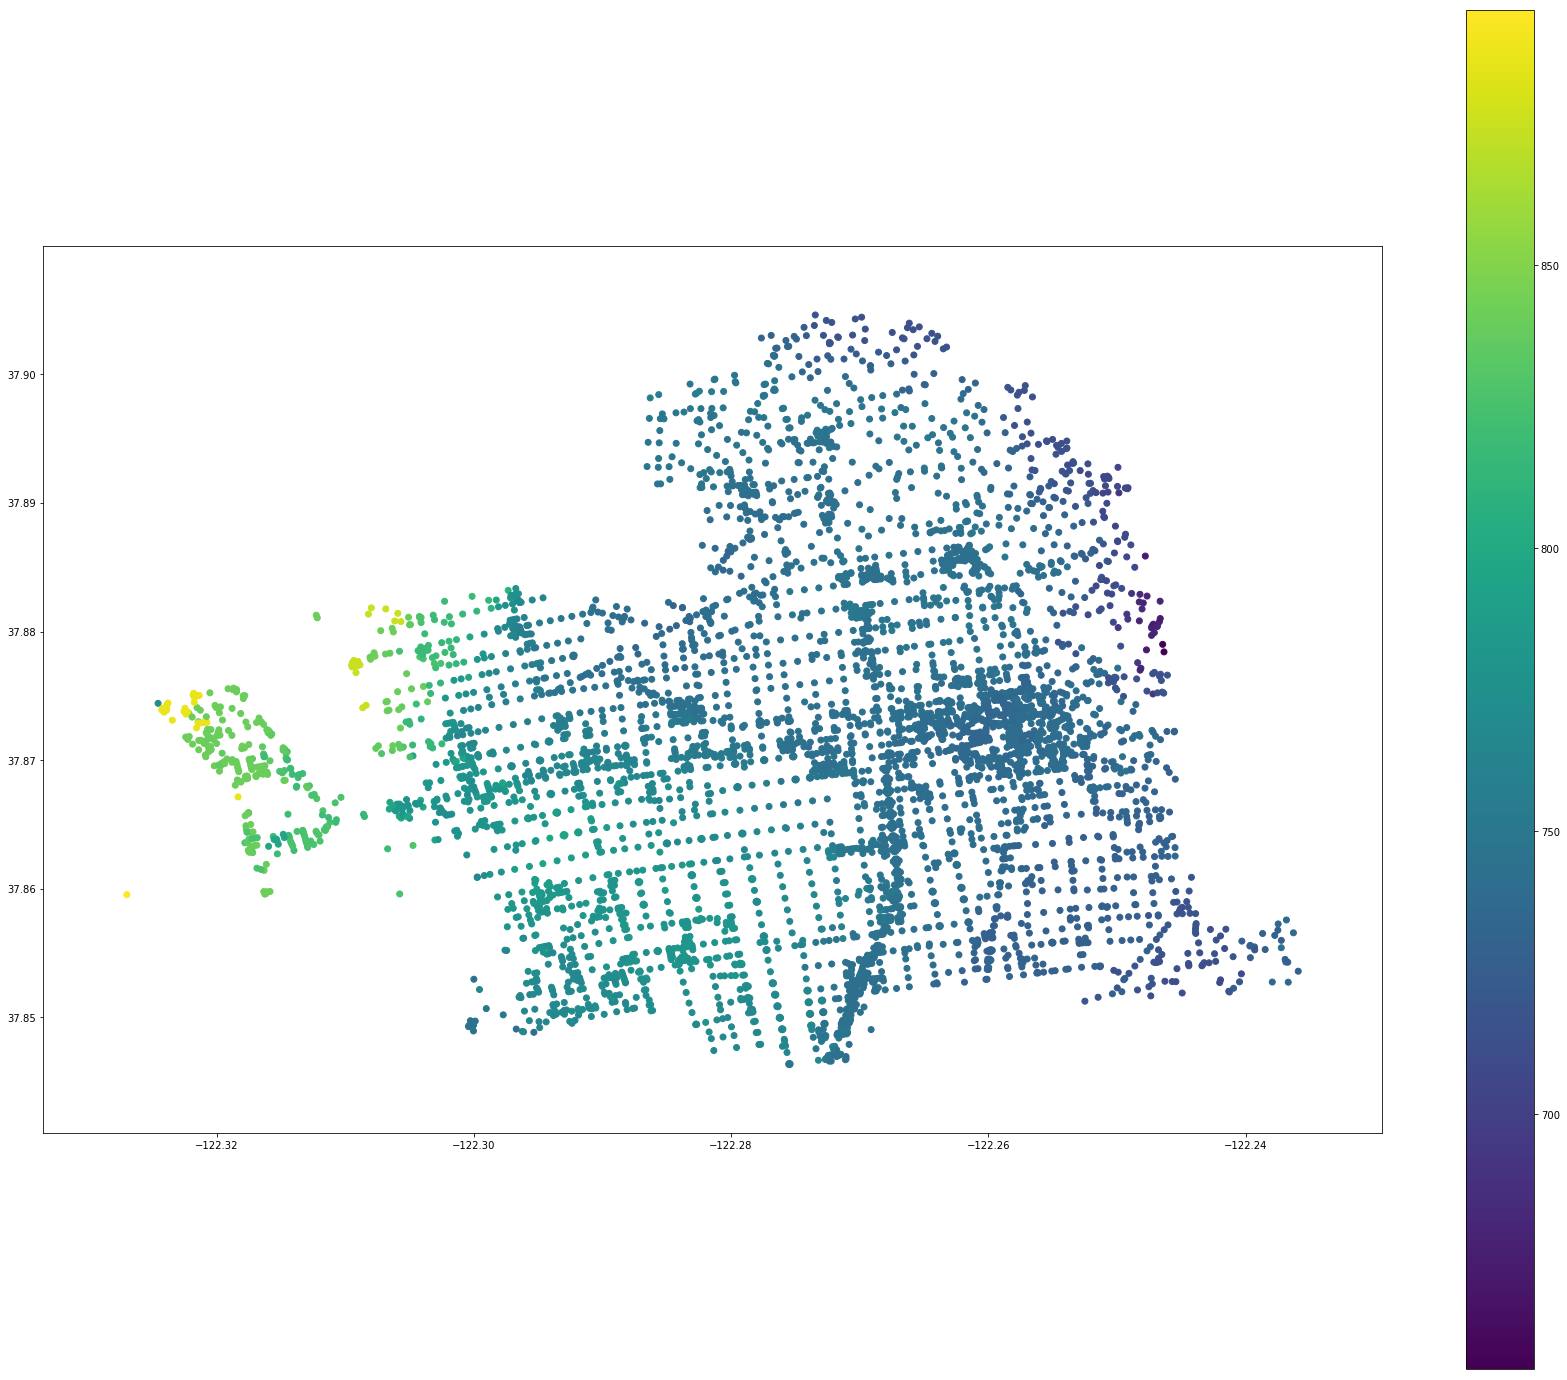

In [192]:
nodes.plot(figsize=(30, 25), column="4000meters", legend=True)

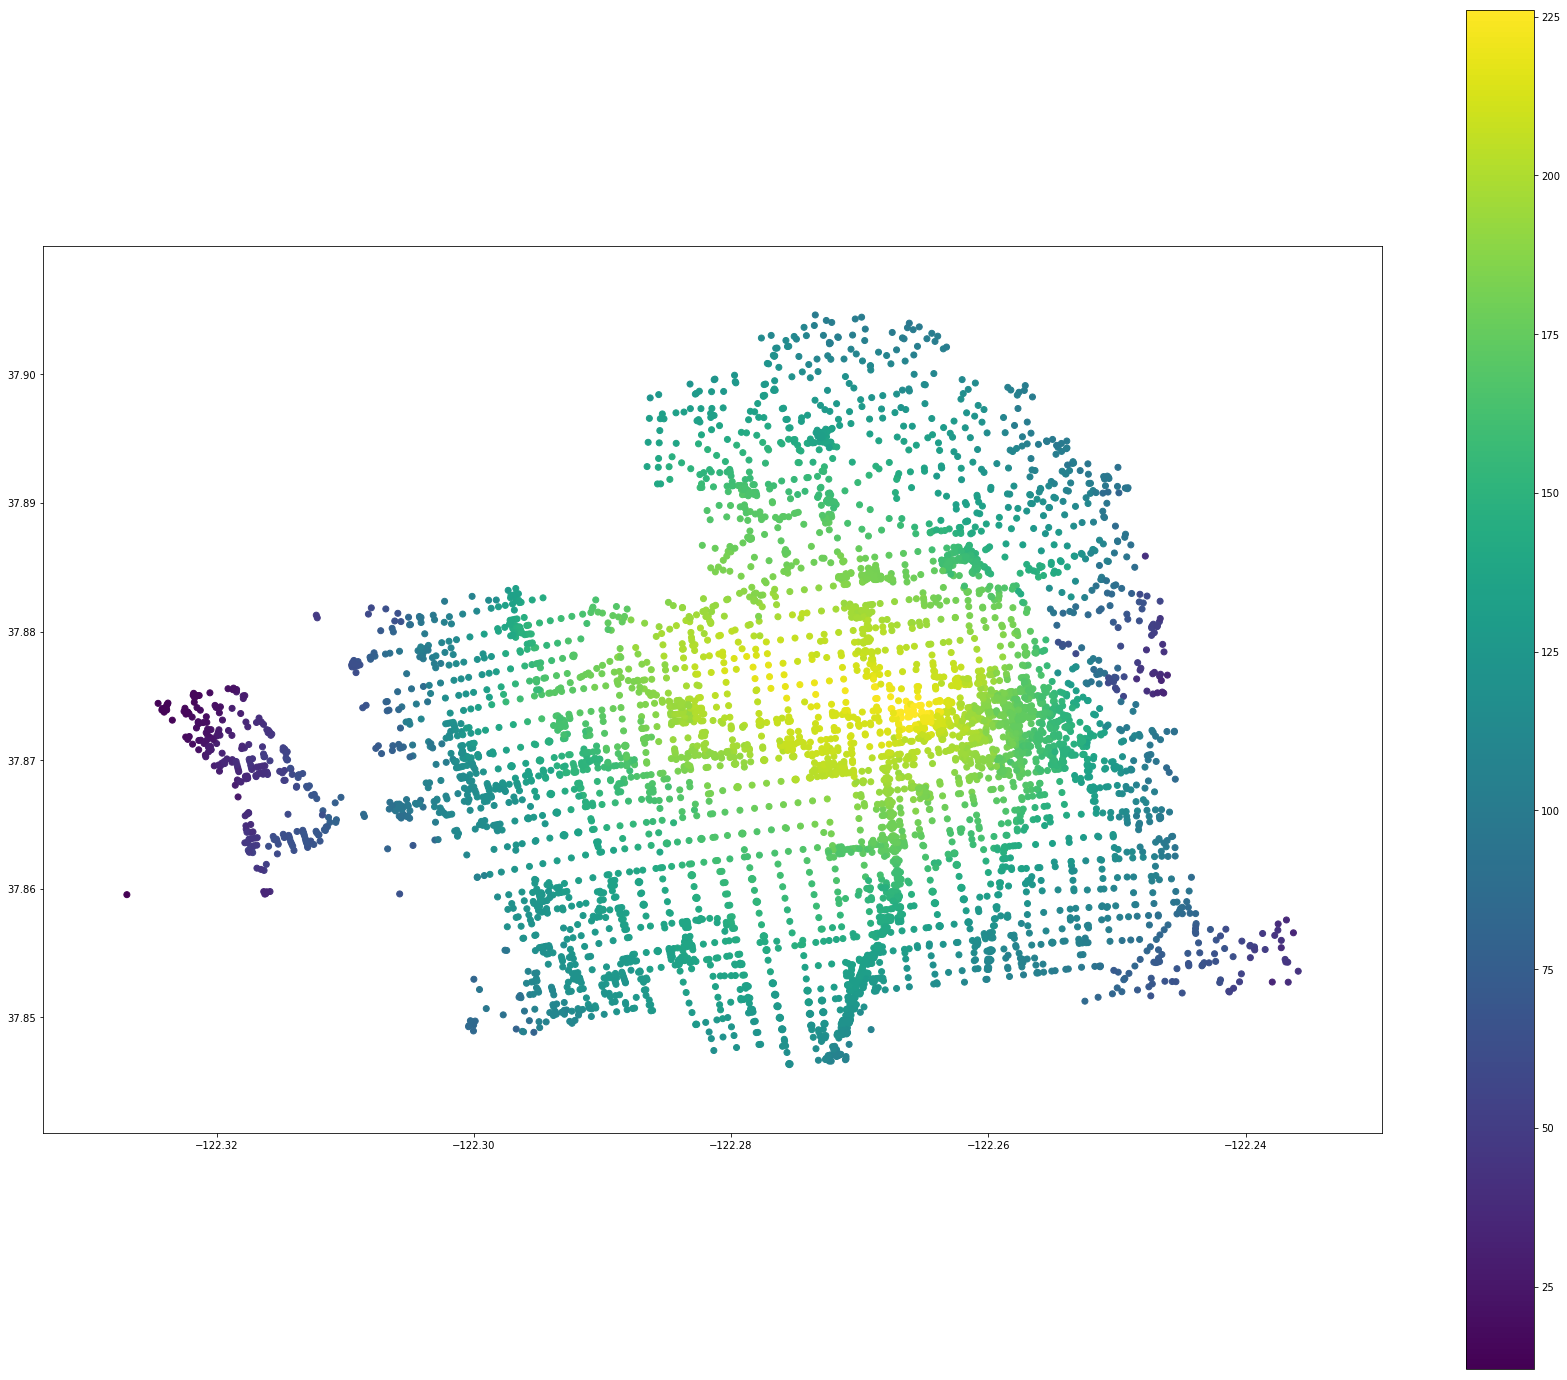

In [195]:
nodes["tmp"] = net.aggregate(4000, type="count", decay="flat")
nodes.plot(figsize=(30, 25), column="tmp", legend=True)

### todo
* plot of voronoi instead of intersections
* use set under different names
* do knn on the network
* talk about accessibility

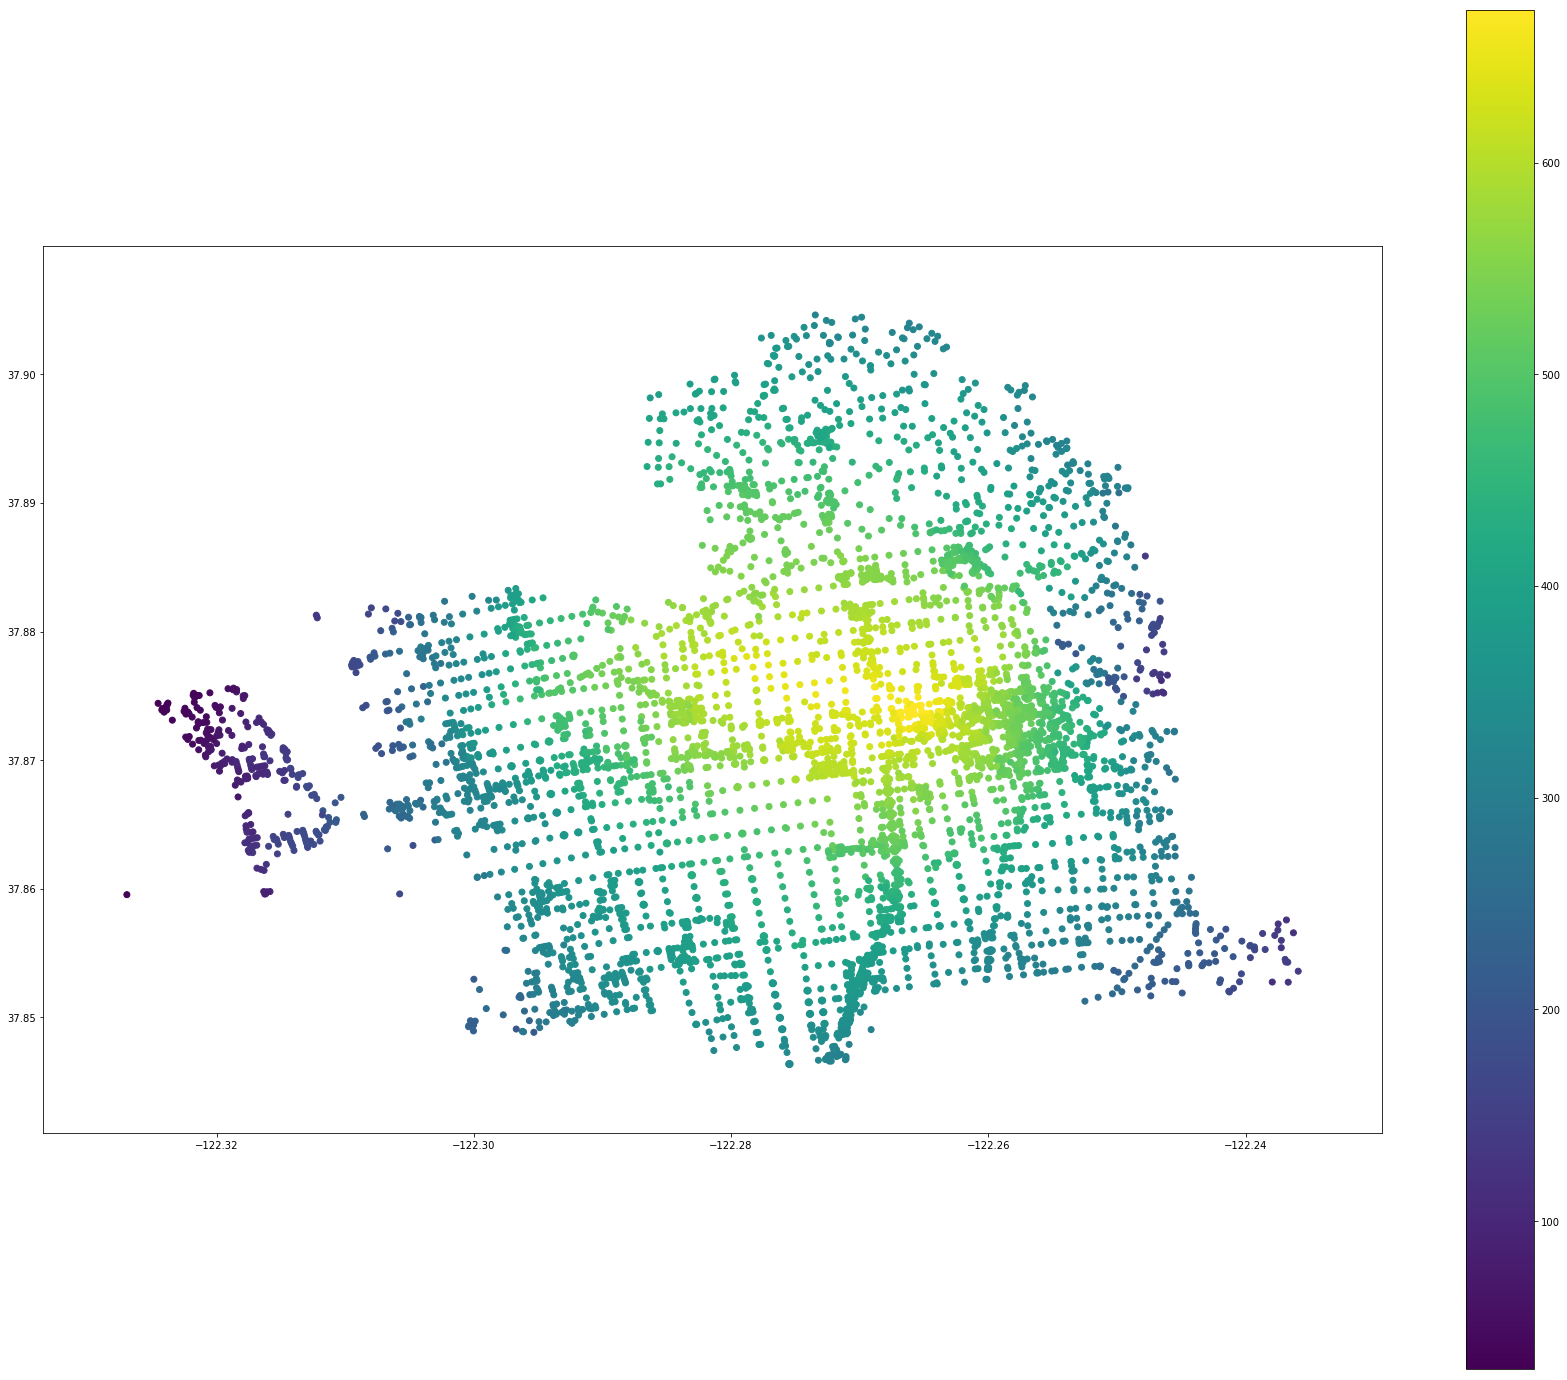

In [196]:
net.set(df.node_ids, variable=df.BEDS)
nodes["tmp"] = net.aggregate(4000, type="sum", decay="flat")
nodes.plot(figsize=(30, 25), column="tmp", legend=True)